In [1]:
'''
This notebook implements a batch run for OFAT analysis
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from joblib import Parallel, delayed

In [2]:
'''
Defaults
'''
height = 20
width = 20
initial_houses = 100
initial_households = 150
savings_lower = 0
savings_upper = 0
price_lower = 100_000
price_upper = 1_000_000
payoff_perc_freehold = 0.0025
inflation = 0.02
house_price = 400_000
chi_parameter = 6.5
maximum_age = 100
minimum_age = 20
age_utility_scaling = 0.01
maximum_moving_age = 65
bank_income_multiplire = 8
fraction_good_houses = 0.05
price_shock_range = 6

In [ ]:
columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 10
max_steps = 2
ofat_size = 5

In [ ]:
def collect_samples(samples, columns, parameter, values):
    df_experiment = pd.DataFrame(columns=columns)
    parameter_name = parameter
    kwargs = {f'{parameter}':values}
    for k in range(int(samples)):
        '''
        Repeat trial with certain parameter k times to apply clt
        '''            
        model = HousingMarket(**kwargs)
        model.run_model(max_steps)
        data = model.datacollector.get_model_vars_dataframe()
        dic = {'Variable': parameter_name, 'Parameter': parameter, 'Gini': data['Gini'].iloc[-1]}
        df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
    return df_experiment

In [ ]:
def run_batch_parallel(problem, i, ofat_size, samples, columns):
    parameter = problem['names'][i]
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    results = Parallel(n_jobs=8)(delayed(collect_samples)(samples, columns, parameter, value)
                       for value in variable_values)
    final = pd.concat(results)
    return final

In [ ]:
def run_batch_parallel_plotter(result, i):
    '''
    This plots the result from running a batch runner in parallel
    '''
    
    fig = plt.plot( figsize = (20,40))
    y = []
    err = []
    x = np.linspace(*problem['bounds'][i], ofat_size)

    for j in range(len(x)):
        series = result['Gini'][int(j*samples):int((j+1)*samples)]
        y.append(series.mean())
        err.append(1.96 * (series.std()/np.sqrt(samples)))

    plt.plot(x, y , c='k')
    plt.fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    plt.ylabel("Gini")
    plt.xlabel(problem['names'][i])
    plt.show()

In [ ]:
'''
This defines the bounds of for the ofat analysis
'''
problem = {
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'bank_income_multiplier'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000],
              [0.001,0.0025],[0.01,0.03],[5,7.5],[1,200]]    
}

columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 20
max_steps = 1000
ofat_size = 10

In [ ]:
results = run_batch_parallel(problem, 4, ofat_size, samples, columns)
run_batch_parallel_plotter(results, 4)

In [ ]:
'''
Old code
'''

def run_batch(problem, i, ofat_size):
    parameter = problem['names'][i]
    parameter_name = parameter
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    df_experiment = pd.DataFrame(columns = ('Variable', 'Parameter', 'Gini'))
    
    for j in variable_values:
        '''
        Iterate over bounds of paramter
        '''
                    
        for k in range(samples):
            '''
            Repeat trial with certain parameter k times to apply clt
            '''            
            model = HousingMarket(parameter := int(j))
            model.run_model(max_steps)
            data = model.datacollector.get_model_vars_dataframe()
            dic = {'Variable': parameter_name, 'Parameter': j, 'Gini': data['Gini'].iloc[-1]}
            df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
        
    return df_experiment

In [ ]:
results = Parallel(n_jobs=8)(delayed(run_batch)(problem, i, ofat_size)
                             for i in range(len(problem['names'])))

In [ ]:
'''
Olde code
'''

fig, axs = plt.subplots(len(problem['names']), figsize = (20,40))


for i, result in enumerate(results):
    y = []
    err = []
    x = np.linspace(*problem['bounds'][i], ofat_size)
    for j in range(len(x)):
        series = result[int(j*samples):int((j+1)*samples)]
        y.append(series['Gini'].mean())
        err.append(series['Gini'].std())
        
    axs[i].plot(x, y)
    axs[i].fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    axs[i].set_ylabel("Gini")
    axs[i].set_xlabel(result.iloc[[0]]["Variable"][0])

## Global Sensitivy Analysis

In [9]:
def run_SOBOL(values, problem, max_steps, counter):
    # build kwargs
    kwargs = {}
    for i, name in enumerate(problem['names']):
        kwargs[name] = values[i]
    model = HousingMarket(**kwargs)
    model.run_model(max_steps)
    data = model.datacollector.get_model_vars_dataframe()
        
    # add run data to the dictionary
    kwargs['Run'] = counter
    kwargs['Gini'] = data['Gini'].iloc[-1]

    return pd.DataFrame(pd.Series(kwargs)).T
    

In [3]:
'''
This section runs Sobol
'''
problem = {
    'num_vars': 8,
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'bank_income_multiplier'],
    'bounds': [[1, 40_000], [50_000, 100_000], [10_000, 90_000], [100_000, 1_000_000],
              [0.001,0.0025],[0.01,0.03],[5,7.5],[6,9]]    
}

In [17]:
replicates = 20
max_steps = 1000
distinct_samples = 4

In [18]:
'''
Generate Saltetlli sample
'''
param_values = saltelli.sample(problem, distinct_samples)
random.shuffle(param_values)

In [22]:
num_runs = len(param_values)*replicates
results = Parallel(n_jobs=8)(delayed(run_SOBOL)(param_values[i%len(param_values)], problem, max_steps, 
                                                i)
                       for i in range(num_runs))

df_global = pd.concat(results)


In [23]:
df_global

,savings_lower,savings_upper,price_lower,price_upper,payoff_perc_freehold,inflation,chi_parameter,bank_income_multiplier,Run,Gini
0,3750.90625,73437.5,47500.0,690625.0,0.001422,0.029375,6.328125,8.53125,0.0,0.768088
0,18750.53125,73437.5,47500.0,690625.0,0.001422,0.029375,6.328125,8.53125,1.0,0.705745
0,18750.53125,73437.5,47500.0,690625.0,0.001422,0.029375,6.328125,8.53125,2.0,0.737386
0,3750.90625,73437.5,47500.0,690625.0,0.001422,0.029375,6.328125,8.53125,3.0,0.730162
0,3750.90625,57812.5,47500.0,690625.0,0.001422,0.029375,6.328125,8.53125,4.0,0.729045
...,...,...,...,...,...,...,...,...,...,...
0,38750.03125,82812.5,57500.0,915625.0,0.001234,0.013125,7.109375,7.59375,1435.0,0.695743
0,33750.15625,60937.5,27500.0,915625.0,0.001797,0.014375,6.484375,6.28125,1436.0,0.712366
0,8750.78125,70312.5,37500.0,240625.0,0.001047,0.018125,5.234375,8.34375,1437.0,0.765722
0,28750.28125,95312.5,77500.0,690625.0,0.002359,0.014375,6.484375,6.84375,1438.0,0.716160


In [24]:
sobal_gini = sobol.analyze(problem, df_global['Gini'].values, print_to_console = True )

                              ST   ST_conf
savings_lower           0.901653  0.257775
savings_upper           0.811563  0.244899
price_lower             1.205831  0.393628
price_upper             1.015032  0.300822
payoff_perc_freehold    1.014097  0.302017
inflation               1.052962  0.269968
chi_parameter           0.798985  0.217119
bank_income_multiplier  0.945653  0.379882
                              S1   S1_conf
savings_lower          -0.032403  0.264285
savings_upper           0.147976  0.229937
price_lower             0.295023  0.341989
price_upper            -0.094455  0.320606
payoff_perc_freehold    0.030806  0.271672
inflation               0.272044  0.342534
chi_parameter           0.279003  0.303293
bank_income_multiplier  0.037164  0.229594
                                                      S2   S2_conf
(savings_lower, savings_upper)                  0.076325  0.332318
(savings_lower, price_lower)                   -0.214689  0.408557
(savings_lower, price_upp

In [25]:
'''
Code from notebook
'''

def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

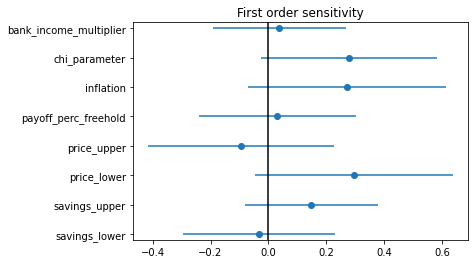

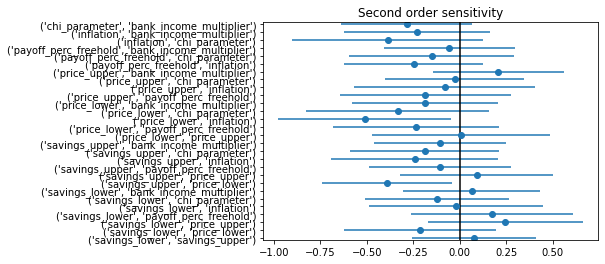

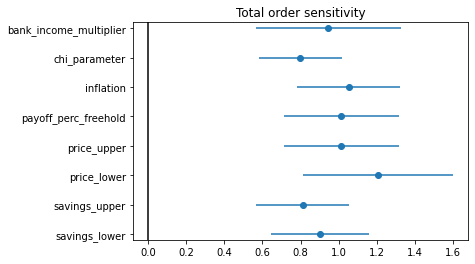

In [26]:
# First order
plot_index(sobal_gini, problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index(sobal_gini, problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index(sobal_gini, problem['names'], 'T', 'Total order sensitivity')
plt.show()